_Version log: Simulated Annealling._

In [13]:
import numpy as np
import CS_functions as cs
from tqdm import tqdm
from matplotlib import pyplot as plt

plt.rcParams.update({'font.size':16})
np.set_printoptions(threshold=sys.maxsize)

In [15]:
file_number = 12
file_name = "1dmockanderrors{:d}".format(file_number)
file_type = ".csv"

In [16]:
reduced_points = 8

target, uncertainties = cs.open_dataset(file_name, file_type)
best_scores = []
best_detectors = []
best_results = []

optlocs_file = "data\\" + file_name +"_optlocs.csv"
detectors = cs.subsample_1d(total_point, reduced_points, "regular")

In [17]:
max_temp = 31
regularization_coeffient = 1e-4 # DECREASE FOR COMPLEX IMAGES (up to 1e-7 (floating point error?)) INCREASE FOR SIMPLE IMAGES (up to 1e-2)
min_seperation= 1
iterations= 5000
max_temp= 31
cooling= 0.995

In [18]:
#########INITAILISATION##########

total_points = len(target)
scores = np.array([])
temps = []
result = cs.compressed_sensing(target[detectors], detectors, total_points, regularization_coeffient)
score = np.linalg.norm((target -result) /uncertainties) #This is the chi-squared
target_temp = max_temp
improvement = True

#######START SIMULATED ANNEALLING###########
for n in tqdm(range(iterations)):
    t = round(target_temp) #reset steps
    new_detectors = np.copy(detectors) #reset detectors
    new_score = np.copy(score) #reset score

    while t > 0:
        random_detector = np.random.randint(0, reduced_points) #random number between 0 and reduced_points. Includes 0. Excludes reduced_points
        current = new_detectors[random_detector]
        previous = -1 if random_detector == 0 else new_detectors[random_detector -1] #consider making the end points fixed. It helps define the length of the detector array.
        next = total_points if random_detector == reduced_points -1 else new_detectors[random_detector +1]
        if previous +min_seperation < current and current < next -min_seperation:
            #detector has space to move forward or back.
            new_detectors[random_detector] += np.random.choice([-1,1])
            t -= 1
        elif previous +min_seperation < current:
            #detector has space to move back.
            new_detectors[random_detector] -= 1
            t -= 1
        elif current < next -min_seperation:
            #detector has space to move forward.
            new_detectors[random_detector] += 1
            t -= 1
        else:
            #detector can't move.
            pass

    temps = temps + [[target_temp, np.linalg.norm(new_detectors -detectors, ord= 1)]] #L1 norm represents the number of times that the detectors were moved

    new_result = cs.compressed_sensing(target[new_detectors], new_detectors, total_points, regularization_coeffient)
    new_score = np.linalg.norm((target -new_result) /uncertainties) #This is the chi-squared

    if new_score < score:
        detectors = new_detectors
        result = new_result
        score = new_score
        improvement = True

    if target_temp <= 1: #When cold, stop optimising and start exploring new possiblities.
        target_temp = max_temp
        improvement = False
    elif improvement: #When hot, stop exploring and start optimising this regime.
        target_temp *= cooling

    scores = np.append(scores, score)

temps = np.array(temps).T

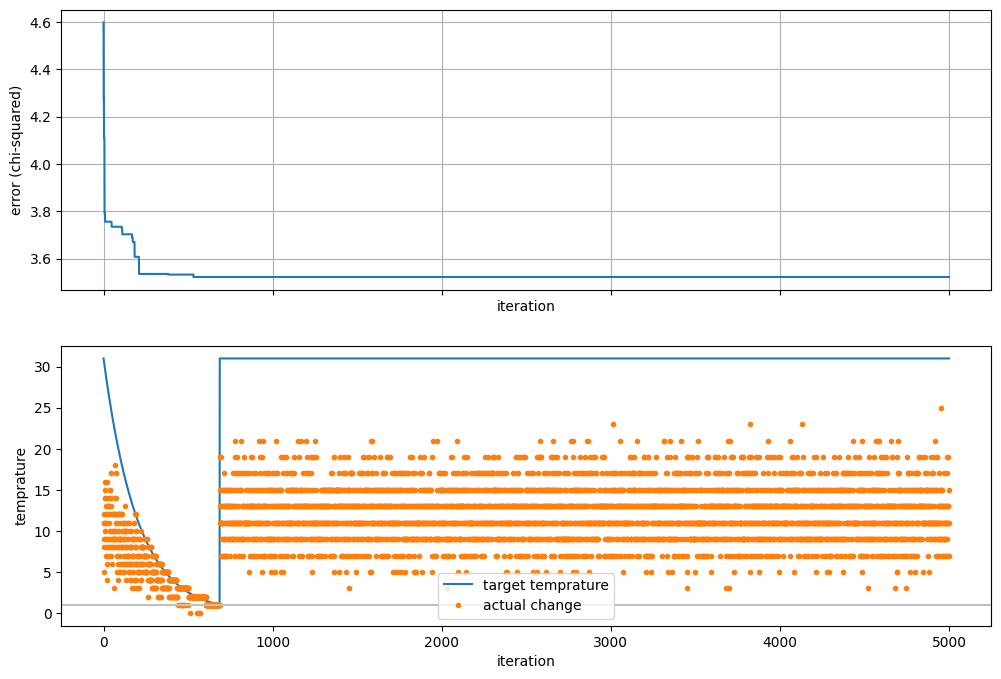

best score = 3.522


In [20]:
fig, axs = plt.subplots(2,1, sharex= True, figsize= (12,8))

axs[0].plot(scores)
axs[0].grid(True)
axs[0].set(ylabel= "error (chi-squared)", xlabel= "iteration")

axs[1].plot(temps[0], label= "target temprature") #target temprature
axs[1].plot(temps[1], marker= ".", linestyle= "None", label= "actual change") #actual temprature due to bounds constraints.
axs[1].hlines(1, 0, 1, color= "silver", transform=axs[1].get_yaxis_transform())
axs[1].set(ylabel= "temprature", xlabel= "iteration")
axs[1].legend()

plt.show()

print("best score = {:.3f}".format(score))